## Bloque 0 – Imports, Drive y rutas generales (TODOS los días)

In [1]:
!pip install scikit-learn joblib --quiet

from google.colab import drive
drive.mount("/content/drive")

from pathlib import Path
import pandas as pd
import numpy as np

# ============ RUTAS BASE ============
# Carpeta donde tienes TODOS los CSV FULL de CICIDS2017
BASE_CIC = Path("/content/drive/MyDrive/Colab Notebooks/Datasets/CIC-IDS2017-Full")

# Carpeta donde vas a ir guardando TODOS los conn.log generados con Zeek
BASE_CONN = Path("/content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017/conn_logs")

# Carpeta donde se guardarán modelos y datasets derivados
OUT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017")

# ============ LISTA DE CSVs CICIDS2017 (FULL) ============
CIC_FILES = [
    "Monday-WorkingHours.pcap_ISCX.csv",
 #   "Tuesday-WorkingHours.pcap_ISCX.csv",
    "Wednesday-workingHours.pcap_ISCX.csv",
    "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
    "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
    "Friday-WorkingHours-Morning.pcap_ISCX.csv",
    "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
    "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
]

# ============ LISTA DE conn.log DE ZEEK ============
# De momento solo tienes Thursday; cuando generes más, los vas agregando aquí
CONN_FILES = [
     "conn_monday_full.log",   # ya lo tienes
     "conn_thursday_full.log",
     "conn_wednesday_full.log",
     "conn_thursday_full.log",
     "conn_friday_full.log",
]

# Ruta del modelo de salida
MODEL_OUT_PATH = OUT_DIR / "rf_cicids2017_zeek_multiday.pkl"

print("BASE_CIC:", BASE_CIC)
print("BASE_CONN:", BASE_CONN)
print("CSV CICIDS:", CIC_FILES)
print("CONN logs Zeek:", CONN_FILES)
print("Modelo se guardará en:", MODEL_OUT_PATH)


Mounted at /content/drive
BASE_CIC: /content/drive/MyDrive/Colab Notebooks/Datasets/CIC-IDS2017-Full
BASE_CONN: /content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017/conn_logs
CSV CICIDS: ['Monday-WorkingHours.pcap_ISCX.csv', 'Wednesday-workingHours.pcap_ISCX.csv', 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', 'Friday-WorkingHours-Morning.pcap_ISCX.csv', 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv']
CONN logs Zeek: ['conn_monday_full.log', 'conn_thursday_full.log', 'conn_wednesday_full.log', 'conn_thursday_full.log', 'conn_friday_full.log']
Modelo se guardará en: /content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017/rf_cicids2017_zeek_multiday.pkl


## Bloque 1 – Funciones helper para leer Zeek y CICIDS

In [2]:
def read_zeek_conn(path: Path) -> pd.DataFrame:
    """
    Lee un conn.log de Zeek:
    - Busca la línea '#fields'
    - Usa esos campos como nombres de columnas
    - Ignora comentarios
    """
    path = str(path)
    cols = None
    with open(path, "r") as f:
        for line in f:
            if line.startswith("#fields"):
                cols = line.strip().split("\t")[1:]
                break
    if cols is None:
        raise ValueError(f"No se encontró la línea '#fields' en {path}")

    df = pd.read_csv(
        path,
        sep="\t",
        comment="#",
        header=None,
        names=cols,
        low_memory=False,
    )
    return df


def load_all_conn() -> pd.DataFrame:
    frames = []
    for fname in CONN_FILES:
        full_path = BASE_CONN / fname
        print("Leyendo conn.log:", full_path)
        df = read_zeek_conn(full_path)
        df["__source_conn"] = fname  # opcional, para saber de qué archivo vino
        frames.append(df)
    all_conn = pd.concat(frames, ignore_index=True)
    print("all_conn.shape:", all_conn.shape)
    return all_conn


def load_all_cic() -> pd.DataFrame:
    frames = []
    for fname in CIC_FILES:
        full_path = BASE_CIC / fname
        print("Leyendo CICIDS:", full_path)
        df = pd.read_csv(full_path, encoding="latin1", low_memory=False)
        df["__source_cic"] = fname  # opcional
        frames.append(df)
    cic = pd.concat(frames, ignore_index=True)
    cic.columns = cic.columns.str.strip()
    print("cic_total.shape:", cic.shape)
    return cic

## Bloque 2 – Cargar TODO Zeek y TODO CICIDS y hacer el join

In [3]:
print("=== Cargando TODOS los conn.log de Zeek ===")
conn_all = load_all_conn()

print("\n=== Cargando TODOS los CSV FULL de CICIDS2017 ===")
cic_all = load_all_cic()

print("\nPrimeras columnas de CICIDS:")
print(list(cic_all.columns[:15]))

=== Cargando TODOS los conn.log de Zeek ===
Leyendo conn.log: /content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017/conn_logs/conn_monday_full.log
Leyendo conn.log: /content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017/conn_logs/conn_thursday_full.log
Leyendo conn.log: /content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017/conn_logs/conn_wednesday_full.log
Leyendo conn.log: /content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017/conn_logs/conn_thursday_full.log
Leyendo conn.log: /content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017/conn_logs/conn_friday_full.log
all_conn.shape: (2118175, 23)

=== Cargando TODOS los CSV FULL de CICIDS2017 ===
Leyendo CICIDS: /content/drive/MyDrive/Colab Notebooks/Datasets/CIC-IDS2017-Full/Monday-WorkingHours.pcap_ISCX.csv
Leyendo CICIDS: /content/drive/MyDrive/Colab Notebooks/Datasets/CIC-IDS2017-Full/Wednesday-workingHours.pcap_ISCX.csv
Leyendo CICIDS: /content/drive/MyDrive/Colab Notebooks/Datasets/CIC-IDS2017-Full/Thursday-WorkingHours-Morning-WebA

In [4]:
# --- Normalizar CICIDS ---
cic = cic_all.copy()
cic.columns = cic.columns.str.strip()

# Asegúrate de que Flow ID existe
if "Flow ID" not in cic.columns:
    raise ValueError("El CSV de CICIDS no tiene columna 'Flow ID'")

cic["Flow ID"] = cic["Flow ID"].astype(str).str.strip()

# --- Construir Flow ID en Zeek ---
zeek = conn_all.copy()

zeek["Source IP"]        = zeek["id.orig_h"]
zeek["Destination IP"]   = zeek["id.resp_h"]
zeek["Source Port"]      = pd.to_numeric(zeek["id.orig_p"], errors="coerce")
zeek["Destination Port"] = pd.to_numeric(zeek["id.resp_p"], errors="coerce")

proto_map = {"tcp": 6, "udp": 17, "icmp": 1}
zeek["Protocol"] = zeek["proto"].map(proto_map).fillna(0).astype(int)

zeek["Flow ID"] = (
    zeek["Source IP"].astype(str) + "-" +
    zeek["Destination IP"].astype(str) + "-" +
    zeek["Source Port"].astype("Int64").astype(str) + "-" +
    zeek["Destination Port"].astype("Int64").astype(str) + "-" +
    zeek["Protocol"].astype(str)
)


In [5]:
merged = zeek.merge(
    cic[["Flow ID", "Label"]],
    on="Flow ID",
    how="inner",
)

print("merged.shape:", merged.shape)
print("Distribución de etiquetas en merged:")
print(merged["Label"].value_counts())


merged.shape: (9702591, 30)
Distribución de etiquetas en merged:
Label
BENIGN                        4576917
DoS Hulk                      3674719
DDoS                           889723
PortScan                       164696
DoS GoldenEye                  160319
DoS slowloris                  101484
DoS Slowhttptest                93234
Web Attack  Brute Force        25426
Web Attack  XSS                12432
Bot                              2988
Web Attack  Sql Injection        368
Infiltration                      274
Heartbleed                         11
Name: count, dtype: int64


## Bloque 3 – Ingeniería de features (para TODOS los días)

In [6]:
df = merged.copy()

for col in ["duration", "orig_bytes", "resp_bytes", "orig_pkts", "resp_pkts"]:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

df["bytes_total"] = df["orig_bytes"] + df["resp_bytes"]
df["bytes_ratio"] = (df["orig_bytes"] + 1) / (df["resp_bytes"] + 1)

df["pkts_total"] = df["orig_pkts"] + df["resp_pkts"]
df["pkts_ratio"] = (df["orig_pkts"] + 1) / (df["resp_pkts"] + 1)

df["proto_tcp"]  = (df["proto"] == "tcp").astype(int)
df["proto_udp"]  = (df["proto"] == "udp").astype(int)
df["proto_icmp"] = (df["proto"] == "icmp").astype(int)

df["is_http"] = df["id.resp_p"].isin([80, 8080, 443]).astype(int)
df["is_ssh"]  = (df["id.resp_p"] == 22).astype(int)

features = [
    "duration",
    "orig_bytes", "resp_bytes",
    "orig_pkts", "resp_pkts",
    "bytes_total", "bytes_ratio",
    "pkts_total", "pkts_ratio",
    "proto_tcp", "proto_udp", "proto_icmp",
    "is_http", "is_ssh",
]

X = df[features].replace([np.inf, -np.inf], 0).fillna(0)
y = df["Label"].copy()

print("Distribución de clases:")
print(y.value_counts())


Distribución de clases:
Label
BENIGN                        4576917
DoS Hulk                      3674719
DDoS                           889723
PortScan                       164696
DoS GoldenEye                  160319
DoS slowloris                  101484
DoS Slowhttptest                93234
Web Attack  Brute Force        25426
Web Attack  XSS                12432
Bot                              2988
Web Attack  Sql Injection        368
Infiltration                      274
Heartbleed                         11
Name: count, dtype: int64


In [7]:
df = merged.copy()

# Mapear etiquetas originales de CICIDS2017 a clases más generales
# BENIGN se queda igual.
# Ataques se agrupan en categorías: WEB_ATTACK, INFILTRATION, DOS, DDOS,
# PORTSCAN, BOT, BRUTE_FORCE, HEARTBLEED, OTHER.

def map_label(label: str) -> str:
    raw = str(label).strip()
    low = raw.lower()

    # 1) Tráfico normal
    if raw == "BENIGN":
        return "BENIGN"

    # 2) Ataques Web (Thursday)
    if "web attack" in low:
        return "WEB_ATTACK"

    # 3) Infiltración
    if "infiltration" in low:
        return "INFILTRATION"

    # 4) DDoS
    if "ddos" in low:
        return "DDOS"

    # 5) DoS (si luego agregas CSV que lo contengan)
    if "dos " in low:
        return "DOS"

    # 6) PortScan
    if "portscan" in low or "port scan" in low:
        return "PORTSCAN"

    # 7) Bot
    if low == "bot":
        return "BOT"

    # 8) Patator / fuerza bruta (por si luego aparecen FTP-Patator, SSH-Patator)
    if "patator" in low or "brute force" in low or "bruteforce" in low:
        return "BRUTE_FORCE"

    # 9) Heartbleed (si aparece cuando cargues otros días)
    if "heartbleed" in low:
        return "HEARTBLEED"

    # 10) Cualquier etiqueta rara
    return "OTHER"


df["Label_mapped"] = df["Label"].apply(map_label)

print("Distribución de clases (mapeadas):")
print(df["Label_mapped"].value_counts())

Distribución de clases (mapeadas):
Label_mapped
BENIGN          4576917
DOS             4029756
DDOS             889723
PORTSCAN         164696
WEB_ATTACK        38226
BOT                2988
INFILTRATION        274
HEARTBLEED           11
Name: count, dtype: int64


In [8]:
# Ingeniería de features como ya tienes
for col in ["duration", "orig_bytes", "resp_bytes", "orig_pkts", "resp_pkts"]:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

df["bytes_total"] = df["orig_bytes"] + df["resp_bytes"]
df["bytes_ratio"] = (df["orig_bytes"] + 1) / (df["resp_bytes"] + 1)

df["pkts_total"] = df["orig_pkts"] + df["resp_pkts"]
df["pkts_ratio"] = (df["orig_pkts"] + 1) / (df["resp_pkts"] + 1)

df["proto_tcp"]  = (df["proto"] == "tcp").astype(int)
df["proto_udp"]  = (df["proto"] == "udp").astype(int)
df["proto_icmp"] = (df["proto"] == "icmp").astype(int)

df["is_http"] = df["id.resp_p"].isin([80, 8080, 443]).astype(int)
df["is_ssh"]  = (df["id.resp_p"] == 22).astype(int)

features = [
    "duration",
    "orig_bytes", "resp_bytes",
    "orig_pkts", "resp_pkts",
    "bytes_total", "bytes_ratio",
    "pkts_total", "pkts_ratio",
    "proto_tcp", "proto_udp", "proto_icmp",
    "is_http", "is_ssh",
]

X = df[features].replace([np.inf, -np.inf], 0).fillna(0)
y = df["Label_mapped"]


In [9]:
from sklearn.utils.class_weight import compute_class_weight

# X y y como los tenías
X = df[features].replace([np.inf, -np.inf], 0).fillna(0)
y = df["Label_mapped"]

print("Distribución original:")
print(y.value_counts())

# 1) Undersampling ligero de BENIGN
MAX_BENIGN = 60000  # ajustable: 50k-80k está bien
df_bal = (
    df
    .groupby("Label_mapped", group_keys=False)
    .apply(lambda g: g if g.name != "BENIGN" else g.sample(
        min(len(g), MAX_BENIGN), random_state=42
    ))
)

X_bal = df_bal[features].replace([np.inf, -np.inf], 0).fillna(0)
y_bal = df_bal["Label_mapped"]

print("\nDistribución después de balanceo:")
print(y_bal.value_counts())

# 2) class_weight automático según las clases balanceadas
classes = np.unique(y_bal)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_bal)
class_weight = dict(zip(classes, weights))

print("\nclass_weight usado:")
print(class_weight)


Distribución original:
Label_mapped
BENIGN          4576917
DOS             4029756
DDOS             889723
PORTSCAN         164696
WEB_ATTACK        38226
BOT                2988
INFILTRATION        274
HEARTBLEED           11
Name: count, dtype: int64


/tmp/ipython-input-3387955295.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g if g.name != "BENIGN" else g.sample(



Distribución después de balanceo:
Label_mapped
DOS             4029756
DDOS             889723
PORTSCAN         164696
BENIGN            60000
WEB_ATTACK        38226
BOT                2988
INFILTRATION        274
HEARTBLEED           11
Name: count, dtype: int64

class_weight usado:
{'BENIGN': np.float64(10.8034875), 'BOT': np.float64(216.9375), 'DDOS': np.float64(0.728551751500186), 'DOS': np.float64(0.1608557068963977), 'HEARTBLEED': np.float64(58928.11363636364), 'INFILTRATION': np.float64(2365.727189781022), 'PORTSCAN': np.float64(3.935792308252781), 'WEB_ATTACK': np.float64(16.957286925129495)}


In [10]:
from pathlib import Path

# Carpeta de salida (ya la estás usando para el modelo)
OUT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017")

# 1) Definir el orden exacto de columnas para el CSV
cols_alert = [
    # --- Campos crudos de Zeek (para reconstruir la alerta) ---
    "ts", "uid",
    "id.orig_h", "id.orig_p",
    "id.resp_h", "id.resp_p",
    "proto", "service", "conn_state",

    # --- Features base del modelo (vienen de conn.log) ---
    "duration", "orig_bytes", "resp_bytes",
    "orig_pkts", "resp_pkts",

    # --- Features derivadas para ML ---
    "bytes_total", "bytes_ratio",
    "pkts_total", "pkts_ratio",
    "proto_tcp", "proto_udp", "proto_icmp",
    "is_http", "is_ssh",

    # --- Etiqueta de CICIDS2017 ---
    "Label",
]

# 2) Asegurarnos de que todas las columnas existen en df
df_alert = df.copy()

# Si falta 'service' en tu conn.log, la creamos con un valor neutro
if "service" not in df_alert.columns:
    df_alert["service"] = "-"

# Si falta 'conn_state' (no debería, pero por si acaso)
if "conn_state" not in df_alert.columns:
    df_alert["conn_state"] = "-"

# Asegurar que las columnas derivadas existen (por si re-ejecutaste celdas)
for col in [
    "bytes_total", "bytes_ratio",
    "pkts_total", "pkts_ratio",
    "proto_tcp", "proto_udp", "proto_icmp",
    "is_http", "is_ssh",
]:
    if col not in df_alert.columns:
        df_alert[col] = 0

# 3) Crear el DataFrame final con el orden exacto de columnas
missing = [c for c in cols_alert if c not in df_alert.columns]
if missing:
    raise ValueError(f"Faltan columnas en df_alert: {missing}")

df_export = df_alert[cols_alert].copy()

# 4) Guardar el CSV etiquetado
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_CSV_ALERT = OUT_DIR / "zeek_cicids2017_labeled_alert_ready.csv"

df_export.to_csv(OUT_CSV_ALERT, index=False)

OUT_CSV_ALERT

PosixPath('/content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017/zeek_cicids2017_labeled_alert_ready.csv')

In [11]:
import time
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    mean_absolute_error,
    mean_squared_error,
)
from sklearn.preprocessing import LabelEncoder, label_binarize
from pathlib import Path

# ============================
# 1) Datos de entrada
# ============================

# Usa X_bal, y_bal si ya hiciste balanceo; si no, X, y
X_data = X_bal.copy()   # o X
y_data = y_bal.copy()   # o y

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_data,
    y_data,
    test_size=0.3,
    random_state=42,
    stratify=y_data,
)

# ============================
# 2) Entrenamiento con tiempo
# ============================

clf = RandomForestClassifier(
    n_estimators=300,
    n_jobs=-1,
    random_state=42,
    # si tienes class_weight calculado, agrégalo aquí:
    # class_weight=class_weight,
)

t0 = time.time()
clf.fit(X_train, y_train)
t1 = time.time()
train_time_s = t1 - t0

# ============================
# 3) Predicción con tiempo
# ============================

t2 = time.time()
y_pred = clf.predict(X_test)
t3 = time.time()
predict_time_s = t3 - t2

# Necesitamos probabilidades para AUC
if hasattr(clf, "predict_proba"):
    y_proba = clf.predict_proba(X_test)
else:
    y_proba = None

# ============================
# 4) Métricas globales
# ============================

# Accuracy
acc = accuracy_score(y_test, y_pred)

# Precision, Recall, F1 globales (macro y weighted)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_test, y_pred, average="macro", zero_division=0
)
prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_test, y_pred, average="weighted", zero_division=0
)

# AUC (macro) para problema multiclase (One-vs-Rest)
if y_proba is not None:
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)
    # roc_auc_score multiclase macro
    auc_macro = roc_auc_score(y_test_bin, y_proba, average="macro", multi_class="ovr")
else:
    auc_macro = np.nan

# MAE / MSE / RMSE usando etiquetas codificadas como enteros
le = LabelEncoder()
y_true_enc = le.fit_transform(y_test)
y_pred_enc = le.transform(y_pred)

mae  = mean_absolute_error(y_true_enc, y_pred_enc)
mse  = mean_squared_error(y_true_enc, y_pred_enc)
rmse = np.sqrt(mse)

# ============================
# 5) Armar tabla de resultados
# ============================

metrics_row = {
    "Accuracy (%)":  acc * 100,
    "Precision_macro (%)": prec_macro * 100,
    "Recall_macro (%)":    rec_macro * 100,
    "F1_macro (%)":        f1_macro * 100,
    "Precision_weighted (%)": prec_weighted * 100,
    "Recall_weighted (%)":    rec_weighted * 100,
    "F1_weighted (%)":        f1_weighted * 100,
    "AUC_macro (%)": auc_macro * 100 if not np.isnan(auc_macro) else np.nan,
    "MAE":  mae,
    "MSE":  mse,
    "RMSE": rmse,
    "Train_time_s":   train_time_s,
    "Predict_time_s": predict_time_s,
}

metrics_model_df = pd.DataFrame([metrics_row])

print("=== MÉTRICAS GLOBALES DEL MODELO ===")
display(metrics_model_df)

# ============================
# 6) Guardar en CSV
# ============================

OUT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017")
OUT_DIR.mkdir(parents=True, exist_ok=True)

OUT_METRICS_PATH = OUT_DIR / "metrics_rf_multiclase_global.csv"
metrics_model_df.to_csv(OUT_METRICS_PATH, index=False)

print("📁 Métricas globales guardadas en:", OUT_METRICS_PATH)


=== MÉTRICAS GLOBALES DEL MODELO ===


,Accuracy (%),Precision_macro (%),Recall_macro (%),F1_macro (%),Precision_weighted (%),Recall_weighted (%),F1_weighted (%),AUC_macro (%),MAE,MSE,RMSE,Train_time_s,Predict_time_s
0,86.444778,84.590545,76.236709,77.713384,87.556726,86.444778,83.005375,86.214224,0.162665,0.267242,0.516954,908.269233,64.591039


📁 Métricas globales guardadas en: /content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017/metrics_rf_multiclase_global.csv


In [12]:
ataques = merged[merged['Label'] != 'BENIGN']
print("Filas con ataque:", len(ataques))

ataques[['ts','id.orig_h','id.orig_p','id.resp_h','id.resp_p','proto','Label']].head(20)


Filas con ataque: 5125674


,ts,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,Label
962226,1.499343e+09,172.16.0.1,44380,192.168.10.50,80,tcp,DoS Hulk
962227,1.499343e+09,172.16.0.1,44380,192.168.10.50,80,tcp,DoS Hulk
962228,1.499343e+09,172.16.0.1,44380,192.168.10.50,80,tcp,DoS Hulk
962229,1.499343e+09,172.16.0.1,44380,192.168.10.50,80,tcp,DoS Hulk
962230,1.499343e+09,172.16.0.1,44380,192.168.10.50,80,tcp,DoS Hulk
962231,1.499343e+09,172.16.0.1,44380,192.168.10.50,80,tcp,DoS Hulk
962232,1.499343e+09,172.16.0.1,44380,192.168.10.50,80,tcp,DoS Hulk
962233,1.499343e+09,172.16.0.1,44380,192.168.10.50,80,tcp,DoS Hulk
962234,1.499343e+09,172.16.0.1,44380,192.168.10.50,80,tcp,DoS Hulk
962235,1.499343e+09,172.16.0.1,44380,192.168.10.50,80,tcp,DoS Hulk


In [13]:
from sklearn.metrics import confusion_matrix

# Usamos las clases en un orden fijo
labels = sorted(y.unique())

cm = confusion_matrix(y_test, y_pred, labels=labels)
print("Etiquetas (ordenadas):")
print(labels)
print("\nMatriz de confusión (filas = reales, columnas = predichas):")
print(cm)


Etiquetas (ordenadas):
['BENIGN', 'BOT', 'DDOS', 'DOS', 'HEARTBLEED', 'INFILTRATION', 'PORTSCAN', 'WEB_ATTACK']

Matriz de confusión (filas = reales, columnas = predichas):
[[  15900      18     278    1680       0       0     124       0]
 [      6     879       0      11       0       0       0       0]
 [     58       0   71784  195062       0       0      13       0]
 [      0       0     483 1208445       0       0       0       0]
 [      0       0       0       0       3       0       0       0]
 [      0       0       0       0       0      82       0       0]
 [      1       0      58    1615       0       4   47731       0]
 [      0       0       1   11467       0       0       0       0]]


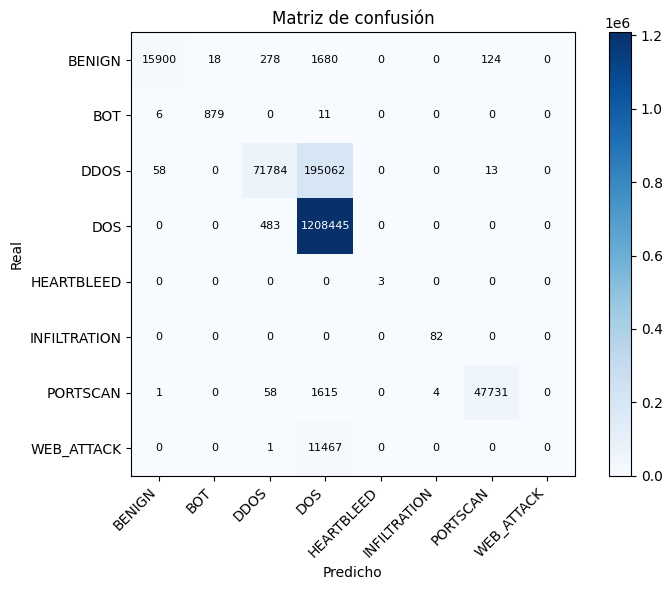

In [14]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))

# *** CAMBIO PRINCIPAL: Se añade cmap='Blues' ***
im = ax.imshow(cm, interpolation="nearest", cmap='Blues')
ax.set_title("Matriz de confusión")
plt.colorbar(im, ax=ax)

# Poner etiquetas en los ejes
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_yticklabels(labels)

ax.set_xlabel("Predicho")
ax.set_ylabel("Real")

# Mostrar los valores dentro de cada celda con color de texto de contraste
threshold = cm.max() / 2.0  # Umbral para decidir el color del texto
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = "white" if cm[i, j] > threshold else "black"
        ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=8, color=text_color)

plt.tight_layout()
plt.show()


In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

# Si aún no lo tienes:
y_pred = clf.predict(X_test)

# Accuracy global
acc = accuracy_score(y_test, y_pred)
print(f"🔹 Accuracy global: {acc:.4f}\n")

# Reporte completo por clase en texto (para revisar rápido)
print("=== CLASSIFICATION REPORT (texto) ===")
print(classification_report(y_test, y_pred, zero_division=0))

# === Métricas por clase en DataFrame (para tesis) ===
labels = sorted(np.unique(y_test))

prec, rec, f1, support = precision_recall_fscore_support(
    y_test,
    y_pred,
    labels=labels,
    zero_division=0,
)

metrics_df = pd.DataFrame({
    "clase": labels,
    "precision": prec,
    "recall": rec,
    "f1_score": f1,
    "soporte": support,
})

# Macro y weighted avg
macro_prec, macro_rec, macro_f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="macro", zero_division=0
)
weighted_prec, weighted_rec, weighted_f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="weighted", zero_division=0
)

global_row = pd.DataFrame([{
    "clase": "GLOBAL_macro",
    "precision": macro_prec,
    "recall": macro_rec,
    "f1_score": macro_f1,
    "soporte": support.sum(),
}])

weighted_row = pd.DataFrame([{
    "clase": "GLOBAL_weighted",
    "precision": weighted_prec,
    "recall": weighted_rec,
    "f1_score": weighted_f1,
    "soporte": support.sum(),
}])

metrics_df = pd.concat([metrics_df, global_row, weighted_row], ignore_index=True)

print("\n=== MÉTRICAS EN TABLA ===")
display(metrics_df)


🔹 Accuracy global: 0.8644

=== CLASSIFICATION REPORT (texto) ===
              precision    recall  f1-score   support

      BENIGN       1.00      0.88      0.94     18000
         BOT       0.98      0.98      0.98       896
        DDOS       0.99      0.27      0.42    266917
         DOS       0.85      1.00      0.92   1208928
  HEARTBLEED       1.00      1.00      1.00         3
INFILTRATION       0.95      1.00      0.98        82
    PORTSCAN       1.00      0.97      0.98     49409
  WEB_ATTACK       0.00      0.00      0.00     11468

    accuracy                           0.86   1555703
   macro avg       0.85      0.76      0.78   1555703
weighted avg       0.88      0.86      0.83   1555703


=== MÉTRICAS EN TABLA ===


,clase,precision,recall,f1_score,soporte
0,BENIGN,0.995929,0.883333,0.936258,18000
1,BOT,0.979933,0.981027,0.980480,896
2,DDOS,0.988706,0.268938,0.422855,266917
3,DOS,0.852050,0.999600,0.919946,1208928
4,HEARTBLEED,1.000000,1.000000,1.000000,3
5,INFILTRATION,0.953488,1.000000,0.976190,82
6,PORTSCAN,0.997138,0.966039,0.981342,49409
7,WEB_ATTACK,0.000000,0.000000,0.000000,11468
8,GLOBAL_macro,0.845905,0.762367,0.777134,1555703
9,GLOBAL_weighted,0.875567,0.864448,0.830054,1555703


In [16]:
from pathlib import Path

OUT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017")

# 1) conn etiquetado completo (todas las columnas Zeek + Label)
OUT_FULL = OUT_DIR / "Thursday_conn_zeek_labeled_full.csv"

# opcional: por si quieres evitar duplicados exactos
merged_unique = merged.drop_duplicates()

OUT_DIR.mkdir(parents=True, exist_ok=True)
merged_unique.to_csv(OUT_FULL, index=False)

OUT_FULL


PosixPath('/content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017/Thursday_conn_zeek_labeled_full.csv')

In [17]:
features = ["duration", "orig_bytes", "resp_bytes", "orig_pkts", "resp_pkts"]

OUT_ML = OUT_DIR / "Thursday_conn_zeek_labeled_ML.csv"

ml_df = merged_unique[features + ["Label"]].copy()
ml_df.to_csv(OUT_ML, index=False)

OUT_ML


PosixPath('/content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017/Thursday_conn_zeek_labeled_ML.csv')

In [18]:
from pathlib import Path
import joblib  # 👈 IMPORTANTE

# Ruta donde quieres guardar el modelo
MODEL_OUT_PATH = Path("/content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017/rf_cicids2017_zeek_multiclass.pkl")

bundle = {
    "model": clf,         # tu RandomForest ya entrenado
    "features": features, # lista de columnas en el mismo orden que usas en el backend
    # opcional pero MUY recomendable:
    # "classes": clf.classes_.tolist(),
}

MODEL_OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
joblib.dump(bundle, MODEL_OUT_PATH)

MODEL_OUT_PATH


PosixPath('/content/drive/MyDrive/Colab Notebooks/Zeek_CICIDS2017/rf_cicids2017_zeek_multiclass.pkl')